# Return  - Baseline

## Introduction

In this notebook we are going to look at an approch based on the **return** rather then the price. The return is defined by:
$$R_t = \frac{C_t - C_{t-1}}{C_{t-1}}$$
with, $C_t$ the close price at time t.

Our goal is to predictict wether the $R_t > R_{t-1}$ or not. Thus our output signal will be a binary signal such that:
- $s_t = 1 \quad$  if  $R_t > R_{t-1}$
- $s_t = 0 \quad$  otherwise

## Baseline model

For our baseline model, we use a **Rademacher distribution** - meaning that the output signal is a random variable $s_B$ such that:
$$P(s_B = 0) = P(s_B = 1) = \frac{1}{2}$$ 

## Back testing

We dinstinguish:
- the **model** : outputs a signal in $\{1, 0, -1\}$
- the **decision making** : takes an action based on the model output
    - if $s_t = 1 \rightarrow$ long
    - if $s_t = 0 \rightarrow$ nothing
    - if $s_t = -1 \rightarrow$ short  

## Implementation

In [2]:
from backtesting import Strategy
from modules.data_preprocessing import *
from modules.add_features import *
from modules.metrics_prediction import *
from modules.metrics_performance import *

### Import

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd
#import random as rd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

### Load data

In [4]:
data = pd.read_csv('data/Binance_BTCUSDT_1h.csv')

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1.637280e+12,2021-11-19 00:00:00,BTC/USDT,56891.62,57247.58,56674.00,57144.98,719.65701,4.099574e+07,19977.0
1,1.637276e+12,2021-11-18 23:00:00,BTC/USDT,56613.30,56987.57,56474.26,56891.62,2553.36240,1.447890e+08,76763.0


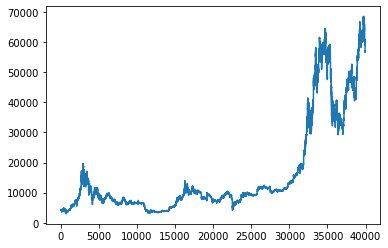

In [5]:
plt.plot(data[::-1].reset_index().close)
data.head(2)

### Data engineering

In [7]:
def data_preprocessing(data, split=0.2):
    
    # Clean data
    data = clean_data(data)
    
    # Add features
    #data = add_technical_indicators(data, lookback_period=30)
    
    # Split data
    train_data, test_data = split_data(data, split=0.2)
    
    # Scale data
    #train_data, test_data = scale_data(train_data, test_data)
    
    # Format data
    train_data = array_to_df(train_data, data.columns)
    test_data = array_to_df(test_data, data.columns)
    
    # Add Return & Signal
    train_data = add_return(train_data)
    test_data = add_return(test_data)
    
    # Add Signal
    # - We want to take on average a position 10% of the time. To do so, we set: alpha = q_90
    q_90 = np.quantile(abs(train_data.Return).iloc[:-1].values, 0.9)
    
    train_data = add_signal(train_data, q_90)
    test_data = add_signal(test_data, q_90)
    
    return train_data, test_data

In [8]:
train_data, test_data = data_preprocessing(data, split=0.2)

train_data.head(2)

,open,high,low,close,Volume USDT,Return,Signal
0,16199.91,16199.91,4261.32,4308.83,190952.85,0.001506,0
1,4308.83,4328.69,4291.37,4315.32,100304.82,0.002093,0


**Signal**
- 1 if $Return \in [\alpha, \inf)$
- 0 if $Return \in [-\alpha, \alpha]$
- -1 if $Return \in (-\inf, -\alpha]$

We want to take on average a position 10% of the time. To do so, we set:
$$\alpha = q_{90}$$

**Reformat data** 

In [9]:
#X_train, r_train, s_train = prepare_data_for_training(train_data, lookback_period=10)
#X_test, r_test, s_test = prepare_data_for_training(test_data, lookback_period=10)

#print(f'Shape X_train: {X_train.shape} | s_train: {s_train.shape}')
#print(f'Shape X_test: {X_test.shape} | s_test: {s_test.shape}')

In [10]:
#train_pos, train_neg = round((s_train>0).sum()/s_train.shape[0],2)*100, round((s_train<0).sum()/s_train.shape[0],2)*100
#test_pos, test_neg = round((s_test>0).sum()/s_test.shape[0],2)*100, round((s_test<0).sum()/s_test.shape[0],2)*100

##print(f'Train set: 1 ({train_pos}%) | 0 ({100-(train_pos+train_neg)}%) | -1 ({train_neg}%)') 
#print(f'Test set: 1 ({test_pos}%) | 0 ({100-(test_pos+test_neg)}%) | -1 ({test_neg}%)') 

### Baseline model

In [11]:
def baseline(X):
    N = X.shape[0]
    s_baseline = np.array([int(rd.random()*3)-1 for i in range(N)])
    return s_baseline

In [12]:
s_baseline = baseline(test_data)
s_baseline = pd.Series(s_baseline)

In [18]:
nb_test_hours = 24*1
rd_start = rd.randint(0, test_data.shape[0] - nb_test_hours)

test_pred = s_baseline[rd_start: rd_start + nb_test_hours].reset_index(drop=True)

test_data_crop = test_data[rd_start: rd_start + nb_test_hours].reset_index(drop=True)
test_close = test_data_crop.close
test_signal = test_data_crop.Signal

In [19]:
test_signal

0     0
1     1
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9    -1
10    0
11    0
12    0
13    1
14    0
15   -1
16    0
17    0
18    0
19    0
20    0
21    0
22   -1
23   -1
Name: Signal, dtype: int64

## Backtest strategy

In [20]:
strat = Strategy(cash=500, fees=0.001)
strat.run(test_signal, test_close, verbose=False)

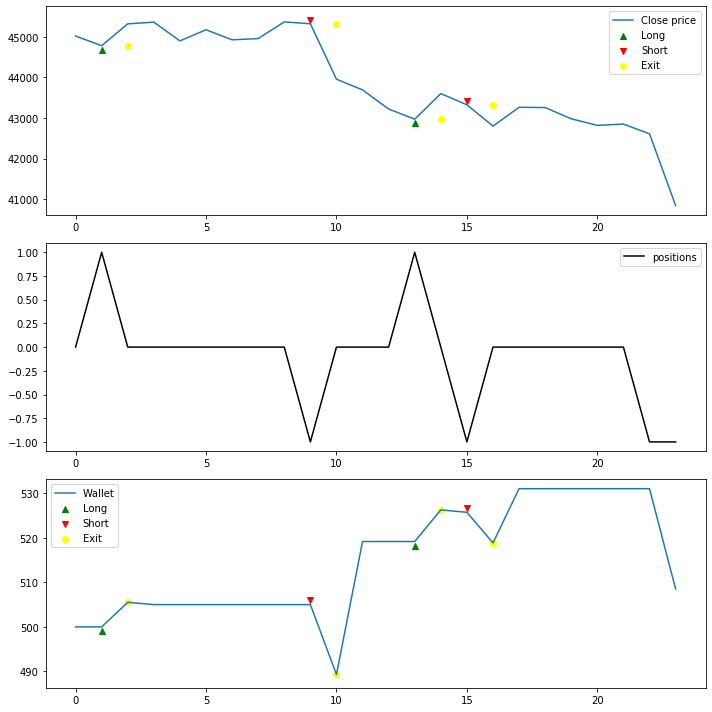

In [21]:
strat.visualize()

### Metrics

In [30]:
cm = confusion_matrix(test_signal, test_pred)
cm
#TN, FP, FN, TP = cm.ravel()
#TPR = TP/(TP+FN)
#FPR = FP/(TN+FP)

array([[  5,   8,   3],
       [104, 111, 111],
       [  9,   5,   4]])

In [44]:
TPR, FPR = get_TPR_FPR(test_signal.values, test_pred.values)

ValueError: too many values to unpack (expected 4)

In [125]:
wacc = WACC(r_test, s_test, s_baseline)

In [126]:
wacc

0.33405445878148465

In [8]:
#Initialize the LSTM
model = Sequential() 
model.add(LSTM(units = 50, activation = 'relu', input_shape = (X.shape[1], 5)))
model.add(Dropout(0.2)) 

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11200     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________


In [9]:
## Time-series cross-validation split
tscv = TimeSeriesSplit(n_splits=5, test_size=3195)

for train_index, test_index in tscv.split(X):
    print("\nTRAIN:", len(train_index), "TEST:", len(test_index))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
history = model.fit(X_train, y_train, epochs = 20, batch_size = 50, validation_data = (X_test, y_test))
    


TRAIN: 15970 TEST: 3195

TRAIN: 19165 TEST: 3195

TRAIN: 22360 TEST: 3195

TRAIN: 25555 TEST: 3195

TRAIN: 28750 TEST: 3195
Train on 28750 samples, validate on 3195 samples
Epoch 1/20
28750/28750 [==============================] - 4s 153us/sample - loss: 2.1835e-04 - val_loss: 2.3215e-05
Epoch 2/20
28750/28750 [==============================] - 3s 103us/sample - loss: 5.2765e-05 - val_loss: 9.1423e-06
Epoch 3/20
28750/28750 [==============================] - 3s 96us/sample - loss: 4.1824e-05 - val_loss: 9.4244e-06
Epoch 4/20
28750/28750 [==============================] - 3s 104us/sample - loss: 4.0786e-05 - val_loss: 2.4837e-05
Epoch 5/20
28750/28750 [==============================] - 3s 101us/sample - loss: 4.0131e-05 - val_loss: 4.2976e-06
Epoch 6/20
28750/28750 [==============================] - 3s 89us/sample - loss: 3.9737e-05 - val_loss: 3.9142e-05
Epoch 7/20
28750/28750 [==============================] - 3s 89us/sample - loss: 3.8707e-05 - val_loss: 2.9718e-05
Epoch 8/20
28750/

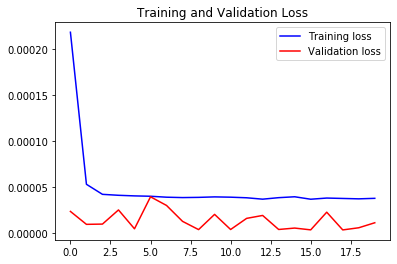

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Test

In [11]:
to_add = np.array([training_data[-lookback_period]])
test_data = np.concatenate([to_add, test_data])

In [12]:
X_test, y_test = build_X_and_y(test_data, lookback_period)
X_test.shape, y_test.shape

((7980, 10, 5), (7980,))

In [13]:
y_pred = model.predict(X_test) 
y_pred.shape

(7980, 1)

In [14]:
y_test.shape

(7980,)

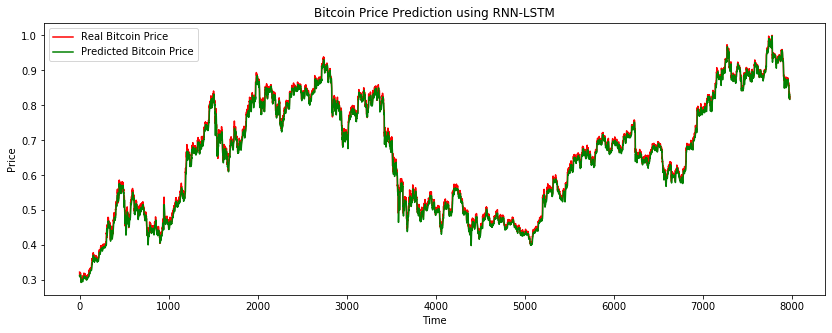

In [15]:
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real Bitcoin Price')
plt.plot(y_pred, color = 'green', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

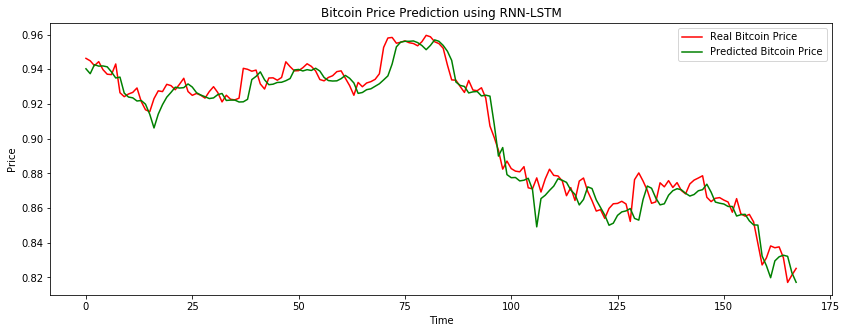

In [16]:
plt.figure(figsize=(14,5))
plt.plot(y_test[-7*24:], color = 'red', label = 'Real Bitcoin Price')
plt.plot(y_pred[-7*24:], color = 'green', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [169]:
def f(s):
    l = []
    s_space = s
    n = len(s)
    
    while n > 0:
        l.append(s_space)
        s = s[2:]
        n = len(s)
        s_space = ' '+s_space[len(s_space)//2:]+s_space[len(s_space)//2:]

    for x in l[:-1]:
        print(x)
    for x in l[::-1]:
        print(x)

#### QRT - Coding challenge

**Q1. Print sablier**

In [209]:
s = 'aaaaa'

n = len(s)
s_space = s
l = []

while len(s) > 0:
    l.append(s_space)
    s = s[2:]
    s_space = ''.join([' ' for k in range((n-len(s))//2)])+s

for x in l[:-1]:
    print(x)
for x in l[::-1]:
    print(x)

aaaaa
 aaa
  a
 aaa
aaaaa


**Q2. Number of neighbors**

In [210]:
s = [[1,0,0,0],[0,0,0,1],[0,1,0,0]]

neighbors = []
x= 1
y= 1

x_set = {x, x+1, x-1}
y_set = {y, y+1, y-1}

for x_ in x_set:
    for y_ in y_set:
        try: 
            neighbors.append(s[x_][y_])
        except:
            continue
print(sum(neighbors))

2


In [214]:
l = [1,5,3]
print(np.median(l))

3.0


In [216]:
sorted(l)

[1, 3, 5]

In [ ]:
lines = (1,2,3)

In [262]:
s = 'CiaonmdGe'

n = int(np.sqrt(len(s)))
l = []
s_list = [s_ for s_ in s]

for i in range(n):
    l.append(s_list[i*n:(i+1)*n])

l = np.array(l).T.reshape(1,-1)
print(l)

In [263]:
l

array([['C', 'o', 'd', 'i', 'n', 'G', 'a', 'm', 'e']], dtype='<U1')

In [264]:
''.join(l[0])

'CodinGame'